# Infestation Modelling

In [1]:
# IMPORTS
import torch
from model import UNetSmall
from model import train_model
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from model import save_sample_predictions
from generate_data import generate_dataset
from dataset import InfestationPairsDataset
from sklearn.model_selection import train_test_split

In [2]:
# EXTENSION
%load_ext autoreload
%autoreload 2

In [3]:
# GLOBAL CONSTANTS
IMG_SIZE = 64
SEQS = 500 # No. of sequences, each with timesteps no. of frames.
TIMESTEPS = 4
BATCH_SIZE = 64
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# GENERATE DATASET IN MEMORY
print("Generating synthetic dataset ...")
X, Y = generate_dataset(n_sequences=SEQS, size=IMG_SIZE, 
                        timesteps=TIMESTEPS, n_seeds_range=(1, 4), 
                        spread_prob_range=(0.3, 0.3), seed=123,
                        neighborhood_size=6)
# X,Y shapes: (N_pairs, 1, H, W)
print("Total pairs:", X.shape[0])

Generating synthetic dataset ...
Total pairs: 1500


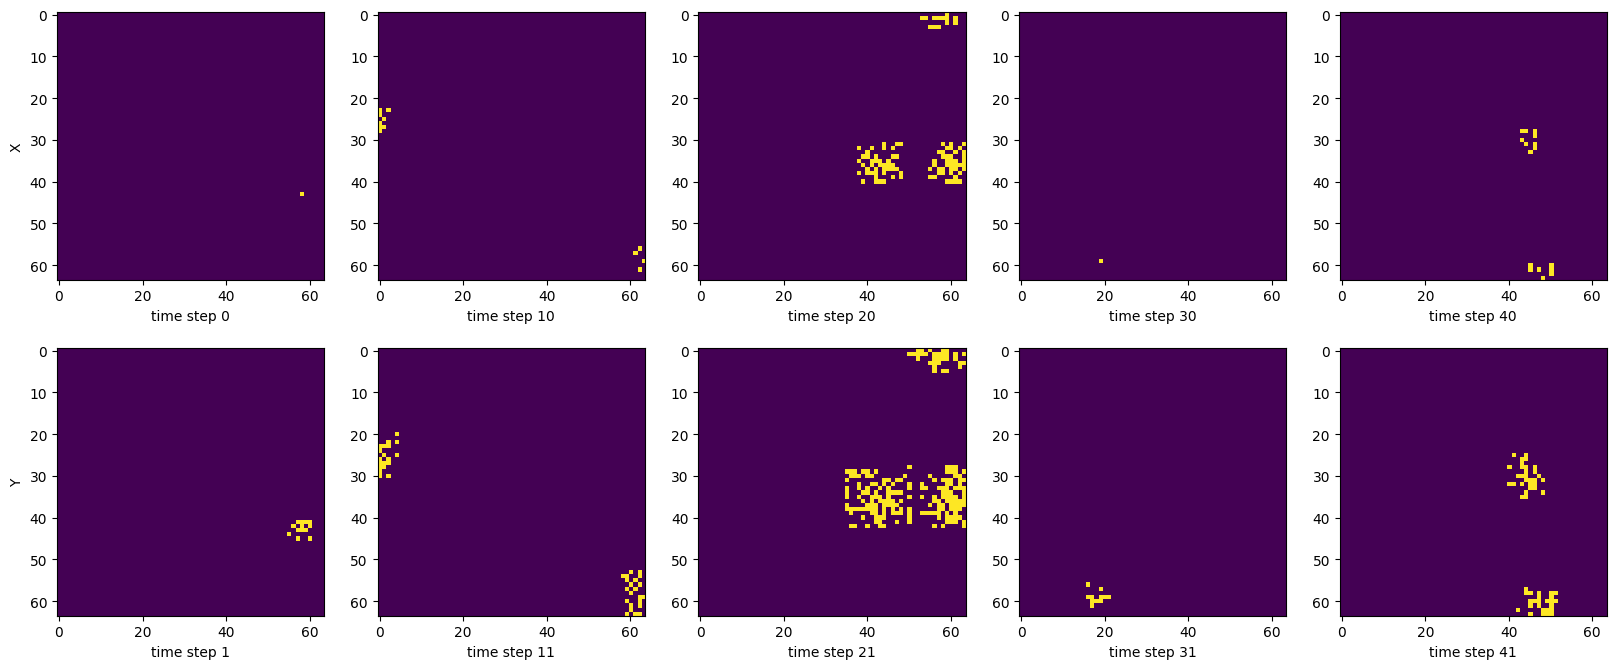

In [5]:
# VIEW 5 SEQUENCE PAIRS
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
offset = 0
stepsize = 10
for i in range(0 + offset, (0 + offset) + (stepsize * 5), stepsize):
    ax[0, i//stepsize].imshow(X[i-offset].reshape(IMG_SIZE, IMG_SIZE))
    ax[0, i//stepsize].set_xlabel(f"time step {i}")
    ax[1, i//stepsize].imshow(Y[i-offset].reshape(IMG_SIZE, IMG_SIZE))
    ax[1, i//stepsize].set_xlabel(f"time step {i+1}")
ax[0, 0].set_ylabel("X")
ax[1, 0].set_ylabel("Y");

In [6]:
# SPLIT INTO TRAINING & VALIDATION SETS
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, 
                                                  random_state=42)
train_ds = InfestationPairsDataset(X_train, Y_train)
val_ds = InfestationPairsDataset(X_val, Y_val)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, 
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, 
                        shuffle=False, num_workers=0)

In [7]:
# INITIALIZE MODEL
model = UNetSmall(in_ch=1, out_ch=1, base_ch=32).to(DEVICE)

In [8]:
# TRAIN MODEL
train_model(model, train_loader, val_loader, device=DEVICE, 
            epochs=EPOCHS, lr=1e-3, save_dir="checkpoints")

Epoch 1/10 — train_loss: 0.4665 val_loss: 0.3391 val_iou: 0.0466
Epoch 2/10 — train_loss: 0.3020 val_loss: 0.2479 val_iou: 0.2602
Epoch 3/10 — train_loss: 0.2300 val_loss: 0.1924 val_iou: 0.2667
Epoch 4/10 — train_loss: 0.1799 val_loss: 0.1503 val_iou: 0.2623
Epoch 5/10 — train_loss: 0.1437 val_loss: 0.1280 val_iou: 0.2588
Epoch 6/10 — train_loss: 0.1171 val_loss: 0.1029 val_iou: 0.2589
Epoch 7/10 — train_loss: 0.0980 val_loss: 0.0842 val_iou: 0.2589
Epoch 8/10 — train_loss: 0.0845 val_loss: 0.0726 val_iou: 0.2590
Epoch 9/10 — train_loss: 0.0746 val_loss: 0.0639 val_iou: 0.2590
Epoch 10/10 — train_loss: 0.0671 val_loss: 0.0576 val_iou: 0.2590
Training finished. Best val IoU: 0.26666210452715555


In [9]:
# SAVE SOME PREDICTIONS
save_sample_predictions(model, val_ds, device=DEVICE, 
                        out_dir="pred_samples", n_samples=3)

Saved sample predictions with labels to pred_samples
